In [1]:
import os
import psycopg2

from astropy import units as u
from astropy.table import Table, join, unique, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky

from desitarget.targets import decode_targetid, encode_targetid, resolve
from desitarget.io import releasedict, release_to_photsys

from tqdm.notebook import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


from astropy.table import Table, vstack, hstack

import psycopg2

from tqdm.notebook import tqdm_notebook

import time


In [15]:
tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_iron_healpix.fits')
tiron

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2852147603439621,198.369130660983,36.5372037049171,10475,main,0.815976335547845,7.38513168100107e-05,4,0.128754377365112,iron/healpix/main/dark/104/10475/redrock-main-dark-10475.fits,EXT,649377,198.36913066098333,36.537203704917076
2399148812795907,198.371733180003,36.4994335406917,10475,main,1.11088784970434,7.48767797671894e-05,4,7.9473560154438,iron/healpix/main/bright/104/10475/redrock-main-bright-10475.fits,EXT,649377,198.37173318000336,36.499433540691676
2399382443917318,184.845242475328,49.8157304793777,10995,main,1.14739342108157,0.000146302276719084,4,2.56771463155746,iron/healpix/main/bright/109/10995/redrock-main-bright-10995.fits,EXT,1008911,184.84524247532795,49.81573047937771
2399634072797192,184.341289722203,70.8283725474297,11965,main,1.51703376230705,6.28979649962091e-05,4,4.76254060305655,iron/healpix/main/bright/119/11965/redrock-main-bright-11965.fits,EXT,241234,184.34128972220284,70.82837254742968
2852141710442505,123.256011148025,36.2652948002806,6448,main,0.00787379494184006,3.4714052819995e-05,0,22.1719104201402,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061
2412337059332105,123.256011148025,36.2652948002806,6448,main,0.0799478243014975,3.26415764231537e-05,4,1.08863945491612,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061
2852141710442501,123.270569418049,36.2759891261316,6448,main,0.125814897161802,5.25734210595906e-05,4,4.58732237294316,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.2705694180487,36.27598912613165
2852189789749253,124.454417230594,38.7904829812355,6454,main,0.0209014343963839,8.37593315854385e-06,0,921.681470951618,iron/healpix/main/dark/64/6454/redrock-main-dark-6454.fits,EXT,1075147,124.45441723059355,38.79048298123546
2412690689490952,122.179783442643,57.7556637029528,7696,main,1.67700904770652,0.000194559932487755,0,10.886064812541,iron/healpix/main/dark/76/7696/redrock-main-dark-7696.fits,EXT,532264,122.17978344264326,57.75566370295283


In [3]:
def get_tf_targets_modified(redux, use_cached=False, verbose=False):
    """Get TF targets from the DESI observations DB for a given spectroscopic reduction.
    
    Parameters
    ----------
    redux : str
        Spectroscopic reduction. E.g., 'everest', 'fuji', ...
    use_cached : bool
        Use cached data rather than re-running the query.
    
    Returns
    -------
    
    tf_targets : Table
        Table of Tully-Fisher observations.
    """
    tf_targets = None

    if os.path.exists(f'tf_targets_{redux}.fits') and use_cached:
        tf_targets = Table.read('cache/tf_targets_{redux}.fits')
    else:
        try:
            db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi', password='')
            cursor = db.cursor()

            query = f"""SELECT rdx.targetid, rdx.target_ra, rdx.target_dec, rdx.mean_fiber_ra, rdx.mean_fiber_dec, rdx.std_fiber_ra, rdx.std_fiber_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, pv.pvtype, pv.sga_id
                   FROM {redux}.healpix_fibermap as rdx, static.pv as pv, {redux}.healpix_redshifts as zd
                   WHERE q3c_join(rdx.target_ra, rdx.target_dec, pv.ra, pv.dec, 1./3600.) 
                         AND zd.targetid = rdx.targetid;"""
                         # AND pv.sga_id IS NOT NULL AND (pv.pvtype LIKE 'TFT' or pv.pvtype LIKE 'EXT' or pv.pvtype LIKE 'SGA');"""
            
            if verbose:
                print(query)

            cursor.execute(query)
            rows = cursor.fetchall()
            tf_targets = Table(list(map(list, zip(*rows))),
                               names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'MEAN_FIBER_RA', 'MEAN_FIBER_DEC','STD_FIBER_RA', 'STD_FIBER_DEC', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN', 'PVTYPE', 'SGA_ID'])

            #- Select only targets with SGA IDs and PV types matching SGA, EXT, and TFT
            select = (tf_targets['SGA_ID'] != None) & \
                     ((tf_targets['PVTYPE'] == 'TFT') | \
                      (tf_targets['PVTYPE'] == 'EXT') | \
                      (tf_targets['PVTYPE'] == 'SGA'))
            tf_targets = tf_targets[select]

            #- Use TARGETID to extract the photometric system used during targeting
            _, _, releases, _, _, _ = decode_targetid(tf_targets['TARGETID'].value)

            photsys = []
            for i, release in enumerate(releases):
                ps = None

                if release in releasedict:
                    ps = release_to_photsys([release])[0].decode('utf-8')
                else:
                    #- Fall-through case: not all SGA center observations are in the main survey.
                    #  In this case, select 'N' or 'S' based on the SGA object's position.
                    ra  = tf_targets['TARGET_RA'][i]
                    dec = tf_targets['TARGET_DEC'][i]
                    c = SkyCoord(ra=ra, dec=dec, unit='degree')

                    #- N: in galactic northern hemisphere and with dec > 32.375. Else, S.
                    isnorth = (c.galactic.b > 0) & (dec > 32.375)
                    ps = 'N' if isnorth else 'S'

                photsys.append(ps)

            #- Complain if the photsys table doesn't match the size of the Vrot table.
            if len(photsys) != len(tf_targets):
                print(f'photsys array of len {len(photsys)} != targets array of len {len(tf_targets)}')

            tf_targets['PHOTSYS'] = photsys

            # tf_targets.write(f'cache/tf_targets_{redux}.fits', overwrite=True)

        except Exception as error:
            print(error)
        finally:
            if db is not None:
                db.close()

    return tf_targets

In [ ]:
iron = get_tf_targets_modified('iron', verbose=True)
iron

In [ ]:
#Fix the fact that for some reason the SGA_ID column was doing weird stuff and not letting me save the table, and then save the table
iron['SGA_ID'] = [str(item) for item in iron['SGA_ID']]
iron.write('test_iron2.fits', overwrite=True)

In [4]:
#Read in iron table from new query
test= Table.read('test_iron2.fits')
test

TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,bytes7,bytes1
-411444222,156.2181500220905,7.1584828480845655,0.1024816376852125,9.091035224678232e-05,GALAXY,0.046789859188720584,2053,TFT,4614,S
-256075243,267.7127650902238,29.4851124724098,0.024937613795555466,2.443082948450574e-05,GALAXY,1544.5199036816193,2560,SGA,447725,S
-255474428,318.1164926597467,-5.284018993812088,0.04895363299977777,7.857217657641379e-05,GALAXY,67.71628514182521,512,TFT,342501,S
-239472210,323.5029072575962,2.5962361580108633,0.05705457943374285,2.4737644271185894e-05,GALAXY,36.335152571089566,2560,TFT,1245160,S
-236269010,159.44155130148636,11.81644015613326,0.053693794815231316,2.0054150033577103e-06,GALAXY,17253.95412647724,2560,SGA,112426,S
-220511122,158.60935975565818,4.101297858301211,0.14424105964001674,2.3386872353021118e-05,GALAXY,100.71361944824457,2560,TFT,1285714,S
-215282046,135.38170916974107,2.899429822113334,0.0706704079002097,9.790452524988413e-06,GALAXY,552.1510838589165,2560,TFT,730406,S
-215264164,139.65430579472775,0.3272206295408149,0.16939400371460273,1.6665502506260876e-05,GALAXY,1103.0728027746081,2560,SGA,460051,S
-211637396,214.40836786160398,38.16543192183721,0.09247420765298109,8.226175105351364e-06,GALAXY,587.4189228154719,2560,TFT,908460,N


In [5]:
#Compare the tables from the two different queries

#Calculate the number of unique target ids that appear in each table

unique_values_set = set(tiron['TARGETID'])

print('Total values for the original query=', len(tiron['TARGETID']))
print('unique values for the original=',len(unique_values_set))


unique_in_test = set(test['TARGETID'])

print('Total values for the test =', len(test['TARGETID']))
print('unique values for the test =',len(unique_in_test))

test_id = set(test['TARGETID'])
tiron_id = set(tiron['TARGETID'])

#Find the number of entries that are shared between the two sets
common_ids = test_id.intersection(tiron_id)
common_ids_list = list(common_ids)
print('Number of data entries the lists have in common=' ,len(common_ids_list))

#Find how many elements are not in both sets
difference_ids1 = test_id.difference(tiron_id)
different_ids1 = list(difference_ids1)

difference_ids2 = tiron_id.difference(test_id)
different_ids2 = list(difference_ids2)
print('Number of data entries in the new test not in the original query=', len(different_ids1))
print('Number of data entries in the original query not in the new test=', len(different_ids2))

Total values for the original query= 99102
unique values for the original= 96661
Total values for the test = 104074
unique values for the test = 96661
Number of data entries the lists have in common= 96661
Number of data entries in the new test not in the original query= 0
Number of data entries in the original query not in the new test= 0


In [4]:
jura = get_tf_targets_modified('jura', verbose=True)

jura['SGA_ID'] = [str(item) for item in jura['SGA_ID']]
jura.write('jura_test.fits', overwrite=True)

jura

SELECT rdx.targetid, rdx.target_ra, rdx.target_dec, rdx.mean_fiber_ra, rdx.mean_fiber_dec, rdx.std_fiber_ra, rdx.std_fiber_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, pv.pvtype, pv.sga_id
                   FROM jura.healpix_fibermap as rdx, static.pv as pv, jura.healpix_redshifts as zd
                   WHERE q3c_join(rdx.target_ra, rdx.target_dec, pv.ra, pv.dec, 1./3600.) 
                         AND zd.targetid = rdx.targetid;


TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,int64,str3,str7,str1
-430502046,134.00013295228783,5.934552839997555,134.0000012447711,5.934402495943119,0.0,0.0,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S
-427872363,61.981718642816155,-22.823913110732356,61.981815755036905,-22.824112647850505,0.01692960597574711,0.01899055577814579,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S
-411444222,156.2181500220905,7.1584828480845655,156.21807676457115,7.1586258676041306,0.0,0.0,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S
-261707523,51.18809619857989,-15.380001206793725,51.18805131712048,-15.379972719695512,0.18443052470684052,0.270201712846756,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S
-260779407,138.32747528464944,17.5639019859795,138.32760054746495,17.56391743552376,0.0,0.0,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S
-256075243,267.7127650902238,29.4851124724098,267.7127035487433,29.485378196733514,0.0,0.0,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S
-255779143,324.7514856412927,-14.285073192391051,324.75157640573354,-14.285173696560276,0.0,0.0,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S
-255474428,318.1164926597467,-5.284018993812088,318.1164721848627,-5.284046207257645,0.0,0.0,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S
-253178294,171.33824183216043,53.64134341804524,171.33828946114534,53.64163818459112,0.0,0.0,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N


In [4]:
#Save the JURA test table and see what it looks like

jura['SGA_ID'] = [str(item) for item in jura['SGA_ID']]
jura.write('jura_test.fits', overwrite=True)
jura_test= Table.read('jura_test.fits')
jura_test

TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,bytes7,bytes1
-430502046,134.00013295228783,5.934552839997555,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S
-427872363,61.981718642816155,-22.823913110732356,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S
-411444222,156.2181500220905,7.1584828480845655,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S
-261707523,51.18809619857989,-15.380001206793725,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S
-260779407,138.32747528464944,17.5639019859795,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S
-256075243,267.7127650902238,29.4851124724098,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S
-255779143,324.7514856412927,-14.285073192391051,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S
-255474428,318.1164926597467,-5.284018993812088,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S
-253178294,171.33824183216043,53.64134341804524,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N


In [5]:
print('Total values for the original query=', len(jura_test['TARGETID']))
print('unique values for the original=',len(set(jura_test['TARGETID'])))

Total values for the original query= 235167
unique values for the original= 230250


In [9]:
print(len(np.unique(jura_test['PVTYPE'])), np.unique(jura_test['PVTYPE'], return_counts=True))

3 (<Column name='PVTYPE' dtype='bytes3' length=3>
EXT
SGA
TFT, array([  3717,  65760, 165690]))


In [18]:
#Try the new query on the everest table to see if it recovers everything like Iron

everest = get_tf_targets_modified('everest', verbose=True)

#Fix the fact that for some reason the SGA_ID column was doing weird stuff and not letting me save the table, and then save the table
everest['SGA_ID'] = [str(item) for item in everest['SGA_ID']]
everest.write('test_everest.fits', overwrite=True)
everest_test= Table.read('test_everest.fits')
everest_test


SELECT rdx.targetid, rdx.target_ra, rdx.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, pv.pvtype, pv.sga_id
                   FROM everest.healpix_fibermap as rdx, static.pv as pv, everest.healpix_redshifts as zd
                   WHERE q3c_join(rdx.target_ra, rdx.target_dec, pv.ra, pv.dec, 1./3600.) 
                         AND zd.targetid = rdx.targetid;


TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,bytes7,bytes1
-106245656,214.40836786160398,38.16543192183721,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,3618,TFT,908460,N
-103279575,193.87126208164,-7.797971929442544,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,1570,EXT,1232665,S
-102479394,256.2862264156173,7.990707719122054,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,3618,SGA,1127864,S
-11020318,216.24332255936653,35.35082958045987,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,1570,TFT,1287197,N
-10865656,214.40835441201924,38.165409435947396,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,3618,TFT,908460,N
-7899575,193.8713209296783,-7.797987680218857,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,1570,EXT,1232665,S
-7099394,256.28620837882397,7.9906791127629555,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,1570,SGA,1127864,S
-1916815,253.1225744031108,33.719069981503495,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,1570,TFT,276273,N
-1326276,220.05055046471682,-0.27826736320203,-0.0019956912923479522,4.1311493573349107e-48,STAR,1.942668892225729e+84,1570,TFT,328560,S


In [10]:
everest_table = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_everest_healpix.fits')
everest_table

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes1,bytes3,int64,float64,float64
2399124498415623,214.013122385853,35.3145314097487,10511,main,0.888985760833643,0.00012204664140238,4,3.5203658118844,--,EXT,1229423,214.01312238585328,35.3145314097487
2412318637948931,214.04164239659,35.3585395889941,10511,main,0.0136311722029368,3.14431330920849e-05,0,113.593752369361,--,EXT,1229423,214.04164239658957,35.35853958899406
1092899764699136,216.00143660376,34.881062410803,10515,sv3,0.511231863324341,0.000149338383958002,4,0.700528137385845,--,EXT,682254,216.0014366037598,34.881062410803
1079700659109889,216.061747702864,34.8365760573346,10515,sv3,0.449087430966155,6.39900937889053e-05,0,9.43113215267658,--,EXT,682254,216.06174770286376,34.836576057334575
1092894798643201,216.061747702864,34.8365760573346,10515,sv3,0.907325853862498,0.000152981500789795,4,0.251146875321865,--,EXT,682254,216.06174770286376,34.836576057334575
2412333884243973,249.490218609158,36.058332514444,9433,main,0.447663677679541,8.88242926270696e-05,4,2.51997595652938,--,EXT,306417,249.4902186091578,36.058332514444025
2412428541296646,246.94530009636,40.9339918585217,9471,main,1.59664910536944,0.000142278099548223,0,16.4966533521656,--,EXT,1141359,246.94530009636003,40.93399185852167
1079037296377859,208.975477166485,5.30336633406908,26091,sv3,1.40202297072998,7.13955539614258e-05,4,8.70454740524292,--,EXT,865490,208.9754771664854,5.303366334069084
1092231435911171,208.975477166485,5.30336633406908,26091,sv3,1.63417441622298,0.000157425962002011,0,10.7714080065489,--,EXT,865490,208.9754771664854,5.303366334069084


In [12]:
#Compare the tables from the two different queries

#Calculate the number of unique target ids that appear in each table

unique_values_set = set(everest_table['TARGETID'])

print('Total values for the original query=', len(everest_table['TARGETID']))
print('unique values for the original=',len(unique_values_set))


unique_in_test = set(everest_test['TARGETID'])

print('Total values for the test =', len(everest_test['TARGETID']))
print('unique values for the test =',len(unique_in_test))

everest_test_id = set(everest_test['TARGETID'])
everest_table_id = set(everest_table['TARGETID'])

#Find the number of entries that are shared between the two sets
common_ids = everest_test_id.intersection(everest_table_id)
common_ids_list = list(common_ids)
print('Number of data entries the lists have in common=' ,len(common_ids_list))

#Find how many elements are not in both sets
difference_ids1 = everest_test_id.difference(everest_table_id)
different_ids1 = list(difference_ids1)

difference_ids2 = everest_table_id.ifference(everest_test_id)
different_ids2 = list(difference_ids2)
print('Number of data entries in the new test not in the original query=', len(different_ids1))
print('Number of data entries in the original query not in the new test=', len(different_ids2))

Total values for the original query= 18180
unique values for the original= 17653
Total values for the test = 19246
unique values for the test = 17653
Number of data entries the lists have in common= 17653
Number of data entries in the new test not in the original query= 0
Number of data entries in the original query not in the new test= 0


In [11]:
jura_test= Table.read('jura_test.fits')
jura_test

TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,bytes7,bytes1
-430502046,134.00013295228783,5.934552839997555,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S
-427872363,61.981718642816155,-22.823913110732356,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S
-411444222,156.2181500220905,7.1584828480845655,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S
-261707523,51.18809619857989,-15.380001206793725,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S
-260779407,138.32747528464944,17.5639019859795,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S
-256075243,267.7127650902238,29.4851124724098,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S
-255779143,324.7514856412927,-14.285073192391051,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S
-255474428,318.1164926597467,-5.284018993812088,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S
-253178294,171.33824183216043,53.64134341804524,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N


In [12]:
jura_test['SGA_ID'] = jura_test['SGA_ID'].astype(np.int32)

In [14]:
jura_test.write('jura_test.fits', overwrite=True)

In [16]:
diffs = tiron['TARGET_RA'] - tiron['RA']
diffs

-3.410605131648481e-13
-3.694822225952521e-13
5.684341886080802e-14
1.4210854715202004e-13
-2.5579538487363607e-13
-2.5579538487363607e-13
3.126388037344441e-13
4.547473508864641e-13
-2.5579538487363607e-13
9.947598300641403e-14
3.126388037344441e-13


In [17]:
diffs.sort()

In [18]:
diffs

-0.0005964179422903726
-0.000499312480314984
-0.0004923576482269709
-0.0004745578369238501
-0.00046717002754803616
-0.0004589130177237166
-0.0004354194299480696
-0.00041874097115623954
-0.00040720784454606473
-0.0004053161319177434
-0.00040066666653615357


In [19]:
avg=np.mean(diffs)
avg

-4.614396167602199e-08

In [20]:
jura_test= Table.read('jura_test.fits')
jura_test

TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1
-430502046,134.00013295228783,5.934552839997555,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S
-427872363,61.981718642816155,-22.823913110732356,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S
-411444222,156.2181500220905,7.1584828480845655,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S
-261707523,51.18809619857989,-15.380001206793725,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S
-260779407,138.32747528464944,17.5639019859795,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S
-256075243,267.7127650902238,29.4851124724098,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S
-255779143,324.7514856412927,-14.285073192391051,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S
-255474428,318.1164926597467,-5.284018993812088,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S
-253178294,171.33824183216043,53.64134341804524,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N


In [22]:
jura_test.write('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/jura_test.fits')

In [ ]:
######## Check the difference between the mean fiber coordinates and the target coordinates

In [3]:
tjura = Table.read('/global/homes/s/sgmoore1/DESI_SGA/TF/queries/jura_test.fits')
tjura

TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64
-430502046,134.00013295228783,5.934552839997555,134.0000012447711,5.934402495943119,0.0,0.0,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S,0.0,0.0
-427872363,61.981718642816155,-22.823913110732356,61.981815755036905,-22.824112647850505,0.01692960597574711,0.01899055577814579,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S,0.0,0.0
-411444222,156.2181500220905,7.1584828480845655,156.21807676457115,7.1586258676041306,0.0,0.0,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S,0.0,0.0
-261707523,51.18809619857989,-15.380001206793725,51.18805131712048,-15.379972719695512,0.18443052470684052,0.270201712846756,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S,0.0,0.0
-260779407,138.32747528464944,17.5639019859795,138.32760054746495,17.56391743552376,0.0,0.0,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S,0.0,0.0
-256075243,267.7127650902238,29.4851124724098,267.7127035487433,29.485378196733514,0.0,0.0,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S,0.0,0.0
-255779143,324.7514856412927,-14.285073192391051,324.75157640573354,-14.285173696560276,0.0,0.0,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S,0.0,0.0
-255474428,318.1164926597467,-5.284018993812088,318.1164721848627,-5.284046207257645,0.0,0.0,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S,0.0,0.0
-253178294,171.33824183216043,53.64134341804524,171.33828946114534,53.64163818459112,0.0,0.0,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N,0.0,0.0


<SkyCoord (ICRS): (ra, dec) in deg
    [(134.00013295,   5.93455284), ( 61.98171864, -22.82391311),
     (156.21815002,   7.15848285), ..., ( 46.7128865 ,  -4.21619977),
     ( 47.98148579,  -2.96656277), ( 47.19488692,  -3.28974167)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(134.00000124,   5.9344025 ), ( 61.98181576, -22.82411265),
     (156.21807676,   7.15862587), ..., ( 46.71283139,  -4.21621324),
     ( 47.9814605 ,  -2.96655727), ( 47.1948614 ,  -3.28972666)]>
     TARGETID         TARGET_RA      ... SKY_FIBER_DIST SKY_FIBER_DIST_R26
----------------- ------------------ ... -------------- ------------------
39628261185029787 148.75616634851673 ...            0.0                0.0
39628261189223221  148.9776889766167 ...            0.0                0.0
39628266855727250  147.8338950921174 ...            0.0                0.0
39628266859923751 148.19843321211746 ...            0.0                0.0
39628272522234361 147.61925873542657 ...            0.0                0.0
396

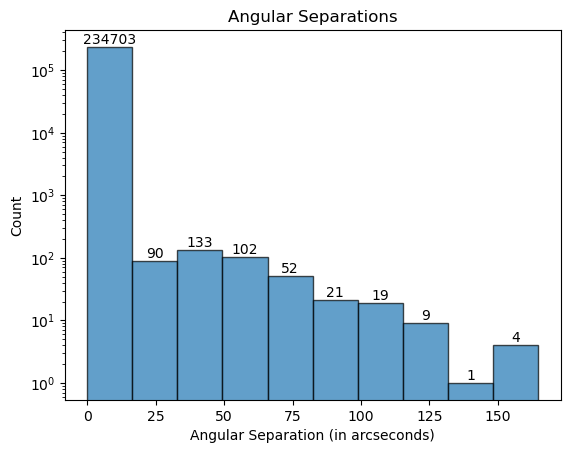

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u


# Convert RA and Dec columns to SkyCoord objects
coords1 = SkyCoord(ra=tjura['TARGET_RA']*u.deg, dec=tjura['TARGET_DEC']*u.deg)
coords2 = SkyCoord(ra=tjura['MEAN_FIBER_RA']*u.deg, dec=tjura['MEAN_FIBER_DEC']*u.deg)

print(coords1)
print(coords2)

# Calculate angular separation between the points
separations = coords1.separation(coords2)

filtered_entries = tjura[separations > 100*u.deg]
print(filtered_entries)
# filtered_entries.write('problematic_differences.fits', overwrite=True)

real_separations = separations[separations < 200 * u.arcsecond]


counts, bin_edges, _ = plt.hist(real_separations.arcsecond, bins=10, edgecolor='black', alpha=0.7)

# Annotate each bin with the count value
for i in range(len(counts)):
    plt.text(bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2, counts[i],
             f'{int(counts[i])}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Angular Separation (in arcseconds)')
plt.ylabel('Count')
plt.title('Angular Separations')
plt.yscale('log')
plt.show()


In [27]:
test=Table.read('problematic_differences.fits')
test

TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64
39628261185029787,148.75616634851673,20.076542527347037,0.0,0.0,0.0,0.0,0.02528835991951838,1.3498482958076885e-05,GALAXY,79.71080778772011,0,TFT,298856,S,0.0,0.0
39628261189223221,148.9776889766167,19.96592180993678,0.0,0.0,0.0,0.0,0.08655344038510374,4.31963289536474e-06,GALAXY,1071.9978474974632,0,TFT,177814,S,0.0,0.0
39628266855727250,147.8338950921174,20.304010211565558,0.0,0.0,0.0,0.0,0.09448356385522699,1.0253575142609597e-05,GALAXY,784.742106705904,0,TFT,630160,S,0.0,0.0
39628266859923751,148.19843321211746,20.25313170543082,0.0,0.0,0.0,0.0,0.12894260361067073,1.3074400034281898e-05,GALAXY,722.9639116227627,0,TFT,1385550,S,0.0,0.0
39628272522234361,147.61925873542657,20.485582944421143,0.0,0.0,0.0,0.0,0.1487607695824821,1.8801748445637147e-05,GALAXY,367.198356077075,0,SGA,993833,S,0.0,0.0
39628272526426833,147.76776757344223,20.502468625208838,0.0,0.0,0.0,0.0,0.09413740426812021,1.714769858585824e-05,GALAXY,5581.138887561858,0,SGA,466716,S,0.0,0.0
39628272534816177,148.34258896280713,20.4485975586792,0.0,0.0,0.0,0.0,0.02003063270387008,2.9476361412380515e-07,GALAXY,861482.8710565567,0,SGA,453176,S,0.0,0.0
39628272539011927,148.69843679196796,20.462517364685862,0.0,0.0,0.0,0.0,0.1094315527471432,2.73304310735367e-05,GALAXY,2189.772282554768,0,TFT,1272445,S,0.0,0.0
39628272543203467,148.80916618243057,20.43150537448006,0.0,0.0,0.0,0.0,0.07889180578012725,1.660794751696423e-05,GALAXY,6043.042103593703,0,TFT,427429,S,0.0,0.0


In [11]:
vrot = Table.read('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/SGA-2020_jura_Vrot.fits')
vrot

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
20,SGA-2020 20,SDSSJ173412.71+572041.6,3331584,263.5529355,57.34490699999999,S?,152.58,0.4487454,0.5333349,0.08364453,24.92448,18.036,False,LEDA-20181114,5,SDSSJ173412.71+572041.6,1,True,263.5529355,57.34490699999999,0.4487454,2635p572,263.55294849855886,57.344862145664294,0.4460123,SB26,152.3756,0.5778338,263.5528114673963,57.34481025685253,10.459747,5.9780583,5.751067,4.821581,1.4858595,3.4448266,5.1149526,6.748707,8.426254,9.720271,11.022999,12.0887985,13.380368,20.656942,20.044735,19.40886,19.194794,18.66572,18.231262,18.599888,18.123905,17.745926,18.256256,17.807074,17.476473,18.040592,17.60353,17.319197,17.926336,17.500519,17.228865,17.85259,17.42695,17.180876,17.811844,17.39206,17.151228,17.783718,17.36542,17.143204,0.02069058,0.026094317,0.03480586,0.05076174,0.08751116,0.10309491,0.08337893,0.10982923,0.13734566,0.031223593,0.046367057,0.0777883,0.015935475,0.020728666,0.032657374,0.012760426,0.014699919,0.022893604,0.010505663,0.011998588,0.018923525,0.010358521,0.011374098,0.017719442,0.010557283,0.0112259,0.017149422,0.010553381,0.011049819,0.017135512,0.010413324,0.010993488,0.01699026,0.010291049,0.010862263,0.017057167,17.6411,0.6362121,0.53480667,2.8045392,1.7123051,17.22401,0.6144014,0.53440714,2.7180903,2.1161501,17.062769,0.44818503,0.43006793,3.1755726,0.97457016,0,0.08361389105924856,5.969831206665643e-06,147.82237894320167,4.528884919879512
32,SGA-2020 32,PGC2644444,2644444,212

In [13]:
problems = set(vrot['SGA_ID']).intersection(set(test['SGA_ID']))
problems

{113581, 287011, 427429, 548591, 564577, 1012058, 1014724, 1272445, 1385550}

In [30]:


# filtered_entries['MEAN_FIBER_RA'] = np.where(filtered_entries['MEAN_FIBER_RA'] == 0.0, filtered_entries['TARGET_RA'], filtered_entries['MEAN_FIBER_RA'])
# filtered_entries['MEAN_FIBER_DEC'] = np.where(filtered_entries['MEAN_FIBER_DEC'] == 0.0, filtered_entries['TARGET_DEC'], filtered_entries['MEAN_FIBER_DEC'])

tjura['MEAN_FIBER_RA'] = np.where(tjura['MEAN_FIBER_RA'] == 0.0, tjura['TARGET_RA'], tjura['MEAN_FIBER_RA'])
tjura['MEAN_FIBER_DEC'] = np.where(tjura['MEAN_FIBER_DEC'] == 0.0, tjura['TARGET_DEC'], tjura['MEAN_FIBER_DEC'])


In [31]:
coords1 = SkyCoord(ra=tjura['TARGET_RA']*u.deg, dec=tjura['TARGET_DEC']*u.deg)
coords2 = SkyCoord(ra=tjura['MEAN_FIBER_RA']*u.deg, dec=tjura['MEAN_FIBER_DEC']*u.deg)

print(coords1)
print(coords2)

# Calculate angular separation between the points
separations = coords1.separation(coords2)

gut_check = tjura[separations > 100*u.deg]
gut_check

<SkyCoord (ICRS): (ra, dec) in deg
    [(134.00013295,   5.93455284), ( 61.98171864, -22.82391311),
     (156.21815002,   7.15848285), ..., ( 46.7128865 ,  -4.21619977),
     ( 47.98148579,  -2.96656277), ( 47.19488692,  -3.28974167)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(134.00000124,   5.9344025 ), ( 61.98181576, -22.82411265),
     (156.21807676,   7.15862587), ..., ( 46.71283139,  -4.21621324),
     ( 47.9814605 ,  -2.96655727), ( 47.1948614 ,  -3.28972666)]>


TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64


In [32]:
tjura

TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64
-430502046,134.00013295228783,5.934552839997555,134.0000012447711,5.934402495943119,0.0,0.0,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S,0.0,0.0
-427872363,61.981718642816155,-22.823913110732356,61.981815755036905,-22.824112647850505,0.01692960597574711,0.01899055577814579,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S,0.0,0.0
-411444222,156.2181500220905,7.1584828480845655,156.21807676457115,7.1586258676041306,0.0,0.0,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S,0.0,0.0
-261707523,51.18809619857989,-15.380001206793725,51.18805131712048,-15.379972719695512,0.18443052470684052,0.270201712846756,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S,0.0,0.0
-260779407,138.32747528464944,17.5639019859795,138.32760054746495,17.56391743552376,0.0,0.0,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S,0.0,0.0
-256075243,267.7127650902238,29.4851124724098,267.7127035487433,29.485378196733514,0.0,0.0,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S,0.0,0.0
-255779143,324.7514856412927,-14.285073192391051,324.75157640573354,-14.285173696560276,0.0,0.0,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S,0.0,0.0
-255474428,318.1164926597467,-5.284018993812088,318.1164721848627,-5.284046207257645,0.0,0.0,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S,0.0,0.0
-253178294,171.33824183216043,53.64134341804524,171.33828946114534,53.64163818459112,0.0,0.0,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N,0.0,0.0


In [35]:
tjura.write('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/desi_pv_tf_jura_healpix.fits', overwrite=True)